In [63]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import joblib
import duckdb
import sys
from pathlib import Path

# Import from local modules
sys.path.append('../src')
import clustering_analysis
import processing_and_visualization

import importlib
importlib.reload(clustering_analysis)
importlib.reload(processing_and_visualization)

from clustering_analysis import print_cluster_examples, summarize_clusters, metacluster_preview
from processing_and_visualization import load_clustered_questions, plot_metacluster_distribution

load_dotenv()
csv_path = os.getenv("DATA_CSV")
parquet_path = os.getenv("DATA_PARQUET")

## Final Analysis of Question Clustering
This notebook reconstructs the clustered question datasets for the *unlabeled*, *chicken*, and *maize* subsets of English questions using the provided cluster label files (<20 MB) and the original full dataset. It also includes tools for inspecting and visualizing the cluster structure.

Together, these pieces allow users to explore the final clustering results without rerunning the full UMAP + HDBSCAN pipeline.

Quick facts about the full dataset:
* 20,304,843 rows in total
* 18,854,432 unique rows
* 5,452,290 unique questions
* 2,940,542 unique questions in English
* 16,283,143 unique responses
* 1,537,291 unique questions with no topic tag

**Note:** Cluster labels are specific to each subset and should not be mixed across datasets.

In [81]:
# Reassemble dataframes.
unlabeled_path = Path('../data/question_clusters_unlabeled.parquet')
chicken_path = Path('../data/question_clusters_chicken.parquet')
maize_path = Path('../data/question_clusters_maize.parquet')

unlabeled_df = load_clustered_questions(parquet_path, unlabeled_path, topic=None)
chicken_df = load_clustered_questions(parquet_path, chicken_path, topic="chicken")
maize_df = load_clustered_questions(parquet_path, maize_path, topic="maize")

In [82]:
# Map meta_label integers to descriptive titles
unlabeled_meta_titles = {
    -1: "Uncategorized", 1: "Soil & Fertilizer", 2: "Pests & Disease", 3: "Animal Husbandry", 4: "Planting & Growth", 
    5: "Markets", 6: "Finance & Loans", 7: "Farming Equipment & Materials", 8: "Weather & Environment", 
    9: "Wefarm Platform",10: "Personal Communication"
}

chicken_meta_titles = {
    -1: "Uncategorized", 1: "Chick Care & Raising", 2: "Nutrition & Feeding", 3: "Pests & Disease",
    4: "Adult Chicken Health & Behavior", 5: "Breeds & Genetics", 6: "Eggs & Reproduction",
    7: "Housing & Equipment", 8: "Business, Markets, & Starting Poultry Projects", 9: "Seasonal & Environmental Effects"
}

maize_meta_titles = {
    -1: "Uncategorized / Noise", 1: "Pests & Disease", 2: "Fertilizer, Soil, & Planting Practices", 3: "Seed Varieties & Regional Adaptation", 
    4: "Yield & Farm Output", 5: "Market & Price Information", 6: "Animal Feed / Alternative Uses", 7: "Wefarm Platform / Miscellaneous"   
}


unlabeled_df['meta_label_titles'] = unlabeled_df['meta_label'].map(unlabeled_meta_titles)
chicken_df['meta_label_titles'] = chicken_df['meta_label'].map(chicken_meta_titles)
maize_df['meta_label_titles'] = maize_df['meta_label'].map(maize_meta_titles)

## Unlabeled questions
This section explores question trends in the unlabeled questions in English, which consists of 643,148 questions-- about 42% of the total number of unlabeled questions. It is evident that non-English questions are more likely to lack a tag, as English questions represent 50.1% of unique questions overall.

These questions were clustered using minimal text cleaning, sentence embeddings (`all-MiniLM-L6-v2`), 5-dimensional UMAP, and HDBSCAN, with a second pass applied to noise (`-1`) questions and metaclusters created for interpretability.

Below, cluster centroids are plotted by their 2D UMAP coordinates, with point sizes normalized to the number of samples in each cluster and color-coded by metacluster. Clicking a metacluster in the legend will hide the others, allowing closer inspection of a single metacluster. Some clusters (e.g., **Personal Communication**) appear very close together in semantic space. For clusters like **Pests & Disease**, subjective inspection shows the metacluster is fairly cohesive; however, the different types of pests (insects, parasites, and monkeys) are likely well-separated from each other, as well as from bacterial diseases.

In [90]:
plot_umap_centroids(unlabeled_df, title="Unlabeled Questions UMAP Centroids by Metacluster", size_scale=1)

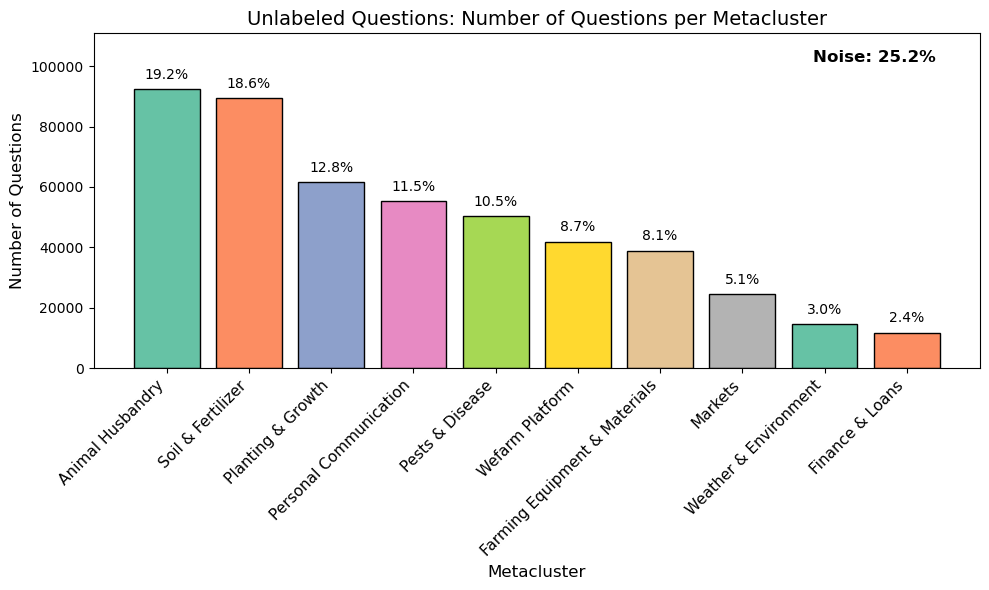

In [91]:
plot_metacluster_distribution(unlabeled_df, title="Unlabeled Questions: Number of Questions per Metacluster")

In [89]:
## I've noticed a cluster that could be classified better-- I moved Cluster 68 from 'Personal Communication' to 'Farming Equipment & Materials'. This cluster seems to be mostly broad questions about farms (e.g. what is a farm?) 
## with maybe an emphasis on how to start one. This change just takes place here, so it will differ from the mapping in 'clustering_questions_unlabeled.ipynb'.
#  
## In case a future user wants to re-label other clusters, here's the mapping:

cluster_to_meta = {
    **dict.fromkeys([0, 12, 15, 16, 52, 53, 54, 57, 58, 59, 60, 83, 84, 87, 88, 91, 92, 98, 101, 108, 113, 118, 124, 126, 130, 137, 147, 151, 173, 175, 177, 182, 183, 188], 4),  # Planting & Growth
    **dict.fromkeys([1, 7, 9, 13, 34, 35, 45, 46, 47, 48, 85, 99, 107, 131, 133, 140, 144, 150, 165, 166, 168, 169], 2),  # Pests & Disease
    **dict.fromkeys([2, 3, 4, 5, 6, 10, 11, 14, 24, 26, 27, 29, 32, 55, 56, 81, 90, 95, 96, 102, 103, 117, 134, 143, 146, 156, 162, 171, 172, 178, 179, 191, 203], 3),  # Animal Husbandry
    **dict.fromkeys([8, 19, 20, 21, 22, 23, 33, 39, 40, 41, 43, 44, 49, 50, 65, 69, 75, 82, 94, 106, 110, 111, 114, 115, 116, 119, 120, 121, 123, 141, 142, 149, 153, 154, 155, 159, 164, 181, 210], 1),  # Soil, Fertilizer, & Animal Feed
    **dict.fromkeys([74, 122, 132, 148, 184, 185, 204, 205, 206, 207, 208, 209, 176, 174], 5),  # Markets
    **dict.fromkeys([17, 18, 71, 72, 186, 167, 163], 6),  # Finance & Loans
    **dict.fromkeys([25, 28, 31, 42, 68, 76, 86, 93, 100, 112, 129], 7),  # Farming Equipment & Materials
    **dict.fromkeys([30, 51, 97, 109, 128, 138, 180, 192], 8),  # Weather & Environment
    **dict.fromkeys([37, 61, 62, 67, 77, 80, 89, 139, 145, 187, 196, 198, 199], 9),  # Wefarm Platform
    **dict.fromkeys([36, 38, 63, 64, 70, 73, 78, 79, 125, 135, 136, 152, 157, 158, 160, 161, 189, 190, 193, 194, 195, 197, 200, 201, 202, 211, 212, 213, 214, 215, 216], 10),  # Personal Communication
    **dict.fromkeys([-1, 66, 104, 105, 127, 170], -1)  # Uncategorized
}
unlabeled_df['meta_label'] = unlabeled_df['cluster'].map(cluster_to_meta)
unlabeled_df['meta_label_titles'] = unlabeled_df['meta_label'].map(unlabeled_meta_titles)

In [ ]:
# Generate summary of clusters, with largest at the top. Includes TF-IDF keywords and 5 example questions by default. Extra stop words can be added for TF-IDF if necessary.
unlabeled_summary = summarize_clusters(unlabeled_df, 
                        text_col='question_content',
                        meta_col='meta_label_titles',
                        sample_questions = 5, 
                        preview = True,
                        sort_by_size = True,
                        #random_samples = True
                        )


=== Cluster -1 (size=157906) ===
Keywords: use, wefarm, does, best, wat
Meta: Uncategorized
Sample questions:
  - Q what are the consiration should I take when to Cary out poughtry
  - Q Kindly connect me to Kevin from Kisii.
  - Where Can I Sell My Thorn mellon?
  - Q Outline the Adivantages of seed dressing?
  - Q Kiambu at which place specific?

=== Cluster 68 (size=17679) ===
Keywords: farm, farming, farmer, farmers, start
Meta: Farming Equipment & Materials
Sample questions:
  - What are the importance of the farm?
  - I Want To Long Out Out From We Farm What Can I Do?
  - Q hi farmers
  - Q, WHAT IS THE BEST N LESS CAPITAL INTENSIVE AGRICULTURAL VENTURE TO PUT UP AS A STARTER
  - Q;
Among the  Mtds  Of Farming,which Method  z  best 2 use in dis season?

=== Cluster 14 (size=15273) ===
Keywords: eggs, egg, incubator, lay, incubation
Meta: Animal Husbandry
Sample questions:
  - Q Need Supplier Of 500crates Of Eggs Every Week.
  - Q Is there any farmer with either kenbro,kari or ra

In [ ]:
# Adjust metacluster_num to examine a specific metacluster. Dependent on summarize_clusters() output.
metacluster_preview(unlabeled_summary, metacluster_num=1, meta_titles=unlabeled_meta_titles)

Previewing Meta-cluster 1: Soil & Fertilizer

=== Cluster 40 (size=12474) ===
Keywords: fertilizer, fertilizers, use, best, dap
Sample questions:
  - Q is DAP WAVUNO IS GOOD 4 PLANTING
  - which type of fertilizer i my use.
  - Q fertilisers like what
  - QWHAT ARE TYPE OF ORGANIC FERTILZER?
  - Q  WHAT  ARE  FERTILIZERS?

=== Cluster 50 (size=7273) ===
Keywords: weeds, weed, weeding, control, farm
Sample questions:
  - Q W/c best way of controlling weeds in the field
  - Q IS IT GOOD TO USE WEEDKILERS
  - Q what is weeding?
  - Q best ways of controlling weed
  - q  how 2 handle  weeds

=== Cluster 41 (size=6711) ===
Keywords: manure, compost, organic, use, make
Sample questions:
  - Q: What are disadvantages of using inorganic manure?
  - Q when preparing composit manure is there need for a manilla?
  - Q Hwat taipes of manure used in uganda
  - q  how is manure important to the soil?
  - Q.in which way will that damage when we all know that it is manure

=== Cluster 110 (size=5219) 

## 'Chicken' Questions

This section will explore questions with the **chicken** tag, which represent 8.5% of the questions in English. Zoning in on one type of livestock question will hopefully reveal more global patterns in what information farmers are seeking about specific animals.

In [101]:
plot_umap_centroids(chicken_df, title="Unlabeled Questions UMAP Centroids by Metacluster", size_scale=1)

As might be expected, the **chicken** focused clusters are more well-resolved than the **unlabeled** clusters-- an **unlabeled** metacluster like **Animal Husbandry** covers subject matter related to chickens, cows, goats, bees, and other animals. Focusing on chicken-specific content allows the clustering to capture finer distinctions within the topic, resulting in tighter, more clearly separated clusters.

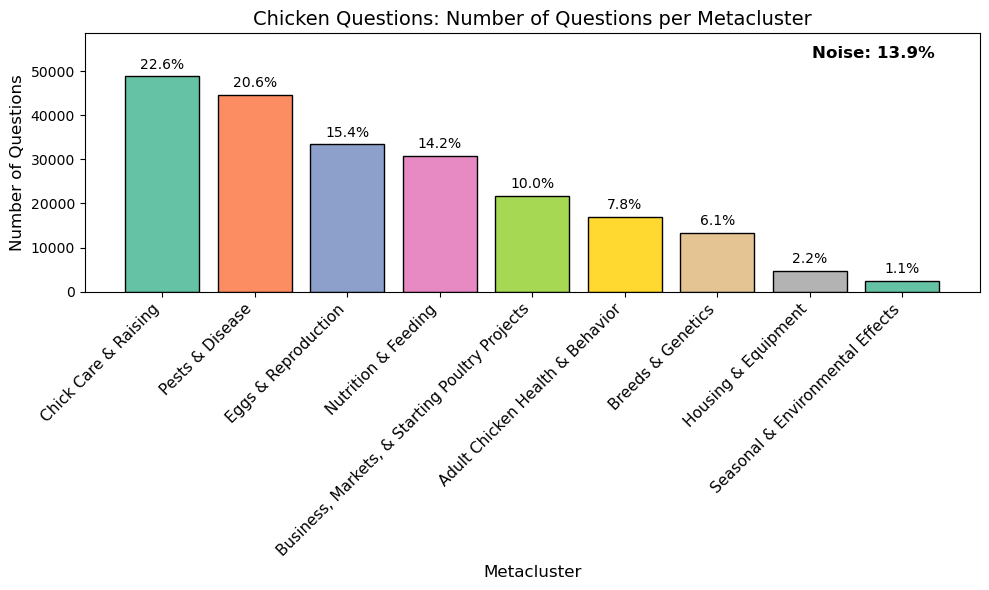

In [102]:
plot_metacluster_distribution(chicken_df, title="Chicken Questions: Number of Questions per Metacluster")

In [ ]:
# Generate summary of clusters, with largest at the top. Includes TF-IDF keywords and 5 example questions by default. Extra stop words can be added for TF-IDF if necessary.
chicken_summary = summarize_clusters(chicken_df, 
                        text_col='question_content',
                        meta_col='meta_label_titles',
                        sample_questions = 5, 
                        preview = True,
                        sort_by_size = True,
                        extra_stop_words = ["chicken", "chickens", "chiken"],
                        #random_samples = True
                        )


=== Cluster -1 (size=34364) ===
Keywords: hen, hens, chicks, eggs, lay
Meta: Uncategorized
Sample questions:
  - Q How can i start with one hen which is a layer to lay fertilized eggs  by a cock to grow into a big hen farm project?
  - Q what makes an egg  break inside the hen?
  - Q     Is my hen normal when it 'family plans' 4 3 yearz?
  - Q inform me of grade Chicken and their feeds, how to get, where and the cost
  - Q. what is the price of a cock or a male chicken?

=== Cluster 0 (size=11062) ===
Keywords: vaccine, chicks, vaccinate, vaccination, vaccines
Meta: Chick Care & Raising
Sample questions:
  - which vacines do we give to day old chicks and hw often do i vacinate them?
  - Q#I have vaccinated my indigenous chicken against newcastle diseases but all over asudden, they are dying one by one,wat could be the problem?
  - Q-i want to chicken vaccination medicines and what they prevent
  - I  request to know which vaccines I give to my kienyeji chicken
  - Q wot is th best vac

In [ ]:
# Adjust metacluster_num to examine a specific metacluster. Dependent on summarize_clusters() output.
metacluster_preview(chicken_summary, metacluster_num=1, meta_titles=chicken_meta_titles)

Previewing Meta-cluster 1: Chick Care & Raising

=== Cluster 0 (size=11062) ===
Keywords: vaccine, chicks, vaccinate, vaccination, vaccines
Sample questions:
  - which vacines do we give to day old chicks and hw often do i vacinate them?
  - Q#I have vaccinated my indigenous chicken against newcastle diseases but all over asudden, they are dying one by one,wat could be the problem?
  - Q-i want to chicken vaccination medicines and what they prevent
  - I  request to know which vaccines I give to my kienyeji chicken
  - Q wot is th best vaccine to a one day old chick

=== Cluster 68 (size=6608) ===
Keywords: chicks, chick, old, day, cost
Sample questions:
  - QHOW MUCH WILL I SALE CHICKS OF ONE MONTH
  - how much is a one day old chick
  - How much money do you sell one small chick?
  - Q where can i get chicks in nakuru @ how much
  - Q where can i buy chicks? Anyone here who has chicks?

=== Cluster 2 (size=5247) ===
Keywords: chiks, chics, best, start, check
Sample questions:
  - Q,w

## 'Maize' Questions